In [1]:
from src.houses import *
from src.agents import *
from src.bidding import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

In [2]:
n = 1_000_000
agents = generate_agents(n)
agents["income"] = get_incomes(agents)
agents["income_bracket"] = find_income_brackets(agents)
size = sys.getsizeof(agents)
print(f"The agents array takes up {size} bytes of memory, which is {size/(1024**3):.6f} GB of memory")
print(agents)

The agents array takes up 31000112 bytes of memory, which is 0.028871 GB of memory
[(     0,  68708.01334729, 0,  4, False, -1, 0., 0.66862065)
 (     1, 246069.60905146, 6, 79, False, -1, 0., 0.6439093 )
 (     2, 251548.86790021, 6, 10, False, -1, 0., 0.6863821 ) ...
 (999997, 266158.91507747, 6, 74, False, -1, 0., 0.7875472 )
 (999998, 306930.15542982, 7, 98, False, -1, 0., 0.66785306)
 (999999, 199680.4956644 , 4, 55, False, -1, 0., 0.7702324 )]


In [ ]:
freq, total = get_freq_and_total(agents)
proportions = get_proportion(freq, total)
agents = check_happiness(agents, proportions)

In [ ]:
utility = get_utilities(agents, proportions)
print(utility)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.9508481  0.8643469  0.87411344 ... 1.         0.8283337  0.9223364 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
bids, neighborhoods_chosen = place_bid(agents, utility)
print(bids)

[     0.        463373.3408088      0.        ...      0.
      0.             0.       ]


In [ ]:
houses = initialize_houses(agents)
print(houses)

[(    0, -1, 27, 100000.) (    1, -1, 67, 100000.)
 (    2, -1,  1, 100000.) ... (99997, -1, 22, 100000.)
 (99998, -1, 36, 100000.) (99999, -1, 54, 100000.)]


In [ ]:
agent_house_mapping(agents, houses)
priced_out_mask = check_priced_out(agents, houses, proportions)
evict_priced_out(agents, houses, priced_out_mask)

In [ ]:
agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
print(f"Iteration 0: {round(np.mean(agents["happy"])*100,3)}% of agents are happy")
print(f"{round(np.sum(agents["neighborhood"]==-1)*100/n,3)}% of agents are homeless")
print()
# happiness check -> bids -> price update -> assignment -> happiness check
max_iter = 100
count = 1
convergence_count = 0
prev_happy, prev_homeless = 0,0
while not np.all(agents["happy"]):
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)

    utilities = get_utilities(agents, proportions)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    happy_agents = round(np.mean(agents["happy"])*100,3)
    homeless_agents = round(np.sum(agents["neighborhood"]==-1)*100/n,3)
    print(f"Iteration {count}: {happy_agents}% of agents are happy")
    print(f"{homeless_agents}% of agents are homeless")
    print()
    count += 1
    """if happy_agents == prev_happy and homeless_agents == prev_homeless:
        convergence_count += 1
        if convergence_count >= 2:
            break # we have converged if both criteria stay the same
    else:
        prev_happy = happy_agents
        prev_homeless = homeless_agents
    if count >= max_iter:
        break"""

# runtime:
# 1 mil agents, not plugged in: 3m 20.9s
# 1 mil agents, plugged in: 2m 40.6s
# 30 mil agents (approx delhi popln): failed to run - out of memory

Iteration 0: 55.576% of agents are happy
0.0% of agents are homeless

Iteration 1: 55.964% of agents are happy
0.991% of agents are homeless

Iteration 2: 53.784% of agents are happy
3.121% of agents are homeless

Iteration 3: 54.843% of agents are happy
2.745% of agents are homeless

Iteration 4: 53.784% of agents are happy
3.121% of agents are homeless

Iteration 5: 54.843% of agents are happy
2.745% of agents are homeless

Iteration 6: 53.784% of agents are happy
3.121% of agents are homeless

Iteration 7: 54.843% of agents are happy
2.745% of agents are homeless

Iteration 8: 53.784% of agents are happy
3.121% of agents are homeless

Iteration 9: 54.843% of agents are happy
2.745% of agents are homeless

Iteration 10: 53.784% of agents are happy
3.121% of agents are homeless

Iteration 11: 54.843% of agents are happy
2.745% of agents are homeless

Iteration 12: 53.784% of agents are happy
3.121% of agents are homeless

Iteration 13: 54.843% of agents are happy
2.745% of agents are 

SystemError: CPUDispatcher(<function allocate_houses at 0x000002732F693100>) returned a result with an exception set

In [ ]:
for i in range(-1, np.max(agents["neighborhood"]+1)):
    print(f"Neighborhood {i}: {np.sum(agents["neighborhood"]==i)} agents")

Neighborhood -1: 2745 agents
Neighborhood 0: 982 agents
Neighborhood 1: 971 agents
Neighborhood 2: 901 agents
Neighborhood 3: 933 agents
Neighborhood 4: 903 agents
Neighborhood 5: 981 agents
Neighborhood 6: 996 agents
Neighborhood 7: 979 agents
Neighborhood 8: 966 agents
Neighborhood 9: 979 agents
Neighborhood 10: 965 agents
Neighborhood 11: 939 agents
Neighborhood 12: 939 agents
Neighborhood 13: 958 agents
Neighborhood 14: 943 agents
Neighborhood 15: 926 agents
Neighborhood 16: 962 agents
Neighborhood 17: 910 agents
Neighborhood 18: 893 agents
Neighborhood 19: 938 agents
Neighborhood 20: 923 agents
Neighborhood 21: 889 agents
Neighborhood 22: 918 agents
Neighborhood 23: 961 agents
Neighborhood 24: 972 agents
Neighborhood 25: 934 agents
Neighborhood 26: 986 agents
Neighborhood 27: 922 agents
Neighborhood 28: 860 agents
Neighborhood 29: 979 agents
Neighborhood 30: 963 agents
Neighborhood 31: 933 agents
Neighborhood 32: 897 agents
Neighborhood 33: 996 agents
Neighborhood 34: 917 agents
N

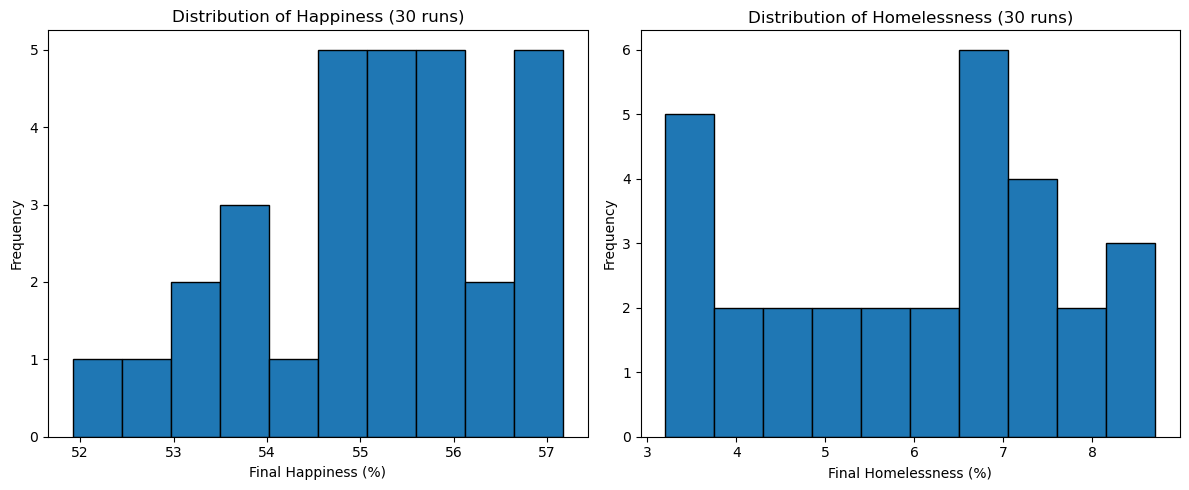

In [ ]:
def run_sim(n, max_iter=100):
    # initialize agents and houses fresh each run
    agents = generate_agents(n)
    houses = initialize_houses(agents)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)

    utilities = get_utilities(agents, proportions)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)

    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    count = 1
    while not np.all(agents["happy"]):
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)

        priced_out_mask = check_priced_out(agents, houses, proportions)
        evict_priced_out(agents, houses, priced_out_mask)

        utilities = get_utilities(agents, proportions)
        bids, neighborhoods_chosen = place_bid(agents, utilities)
        agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
        houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
        
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)
        agents = check_happiness(agents, proportions)

        count += 1
        if count >= max_iter:
            break
    
    # collect final stats
    happiness = np.mean(agents["happy"]) * 100
    homelessness = np.sum(agents["neighborhood"] == -1) * 100 / n
    return happiness, homelessness

# Monte Carlo loop
n = 10_000
runs = 30
results = [run_sim(n) for _ in range(runs)]

happiness_vals, homelessness_vals = zip(*results)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(happiness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Happiness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Happiness (30 runs)")

plt.subplot(1,2,2)
plt.hist(homelessness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Homelessness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Homelessness (30 runs)")

plt.tight_layout()
plt.show()

# first run: 76m 18.7s = 4578.7s
# after skipping utility check for happy agents: 71m 16.6s = 4276.6s (~6.6% speedup)

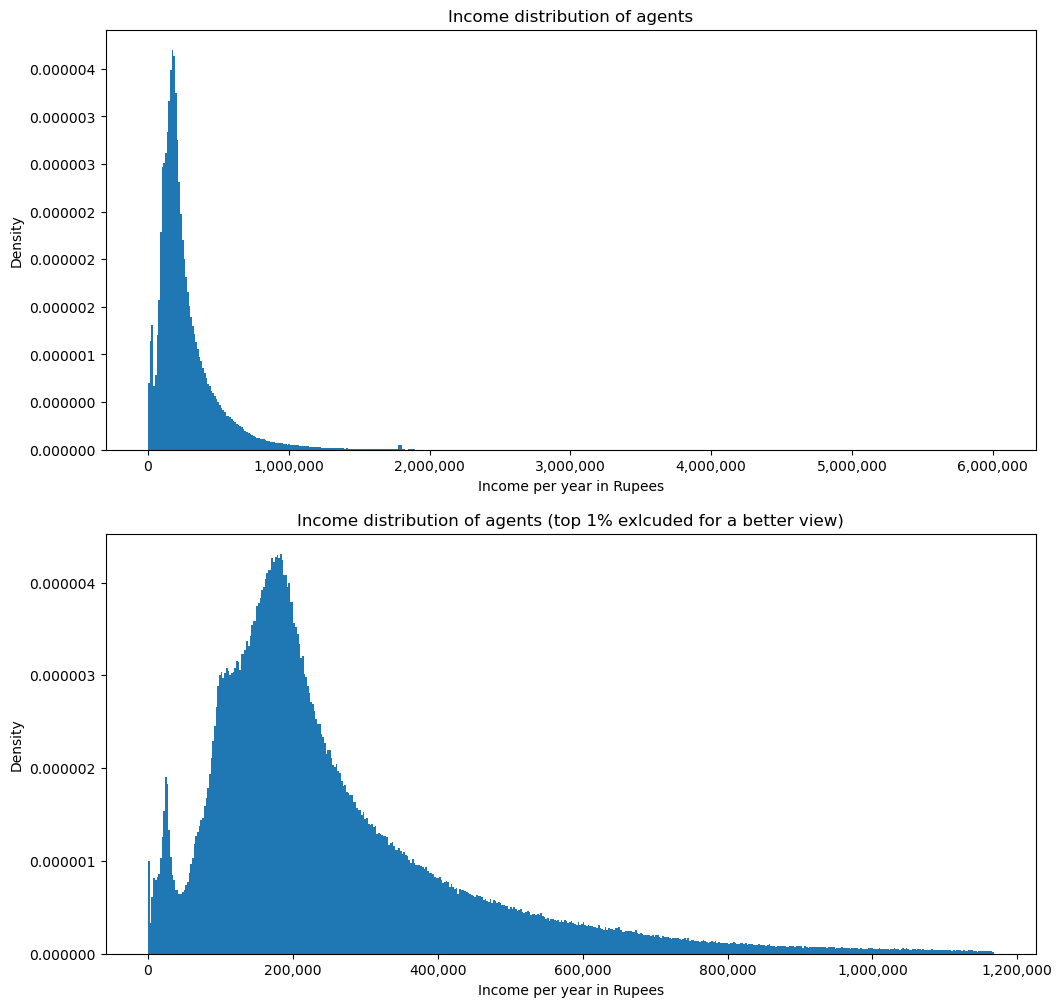

In [3]:
# plot the agents income distribution
incomes = agents["income"]

# Cut off at, say, the 99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))


# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))

plt.show()